In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Professional\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("abdata.csv")

In [4]:
df.head()

,AbGroup,user_id,time_stamp,install_date,event_name,platform,network_name,country_name,InGameTime,LastCompletedLevel,avg_energy_amount,revenue_on_event,revenue_on_other_activities,gold_on_event,gold_on_other_activities
0,Control,d60ebcaecff2dc1d360a8a41271e6fd8a902c107,2020-02-10,2019-11-10,ResourceSpend,itunes,Organic,United Kingdom of Great Britain and Northern I...,276180,345,54.0,0.0,0.0,NaN,NaN
1,Test,f6e385b0ab43d5aea9cfcc408aa84029a4ea5fdb,2020-03-04,2019-11-05,ResourceSpend,itunes,Paid,United States of America,166095,199,50.0,0.0,0.0,NaN,NaN
2,Control,a4c80c8524e2c11cc238553d7b02da01ce2aad66,2020-02-26,2020-01-02,ResourceSpend,itunes,Paid,Canada,240986,84,39.0,0.0,0.0,NaN,NaN
3,Control,7ea2e4599ae33760c307e254839317bd5b17a63c,2020-02-21,2020-01-13,ResourceSpend,itunes,Organic,France,989822,1176,21.0,0.0,0.0,NaN,NaN
4,Control,6495168982929360dc6d84bf0766d8963a7ddc41,2020-02-18,2020-02-05,ResourceSpend,itunes,Paid,Spain,52106,66,43.0,0.0,0.0,500.0,NaN


Данные

Игра содержит особое событие – ивент, для прохождения которого пользователи могут тратить деньги. Группа дизайнеров решила поменять вид окошка покупки ивентовых продуктов. Чтобы оценить результат нововведения, провели АБ тест, разделив пользователей на две группы: контрольную и тестовую (с окошком нового типа).

Задача
Исследовать какая из АБ групп лучше себя показала. Результаты предоставить в понятной для широкой аудитории форме, сопроводив по необходимости графиками/дашбордами/числами. Колонки

AbGroup – имя АБ группы: Control/Test
user_id – id пользователя
time_stamp – день события
install_date – день установки приложения пользователем
event_name – техническое название события (InAppPurchase - в случае покупки за деньги, ResourceSpend в случае покупки за игровую валюту)
platform – платформа google / itunes
network_name – пользователь установил игру по переходу с рекламы (Paid) или нет (Organic)
country_name – страна пользователя
InGameTime – сколько всего пользователь провел в игре секунд
LastCompletedLevel – номер последнего пройденного уровня
avg_energy_amount – сколько в среднем энергии было у пользователя за день
revenue_on_event – ревеню, потраченное на покупку ивентовых продуктов
revenue_on_other_activities – ревеню, потраченное на остальные продукты, включая золото
gold_on_event – золото, потраченное на ивентный прогресс
gold_on_other_activities – золото, потраченное на другие продукты

In [6]:
df["AbGroup"].value_counts(normalize=True)

Control    0.800858
Test       0.199142
Name: AbGroup, dtype: float64

In [8]:
df.groupby('AbGroup')['user_id'].agg(['count', 'nunique'])

,count,nunique
AbGroup,,
Control,558070,89034
Test,138770,22278


In [9]:
df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%Y-%m-%d')

In [11]:
df

,AbGroup,user_id,time_stamp,install_date,event_name,platform,network_name,country_name,InGameTime,LastCompletedLevel,avg_energy_amount,revenue_on_event,revenue_on_other_activities,gold_on_event,gold_on_other_activities
0,Control,d60ebcaecff2dc1d360a8a41271e6fd8a902c107,2020-02-10,2019-11-10,ResourceSpend,itunes,Organic,United Kingdom of Great Britain and Northern I...,276180,345,54.0,0.0,0.0,NaN,NaN
1,Test,f6e385b0ab43d5aea9cfcc408aa84029a4ea5fdb,2020-03-04,2019-11-05,ResourceSpend,itunes,Paid,United States of America,166095,199,50.0,0.0,0.0,NaN,NaN
2,Control,a4c80c8524e2c11cc238553d7b02da01ce2aad66,2020-02-26,2020-01-02,ResourceSpend,itunes,Paid,Canada,240986,84,39.0,0.0,0.0,NaN,NaN
3,Control,7ea2e4599ae33760c307e254839317bd5b17a63c,2020-02-21,2020-01-13,ResourceSpend,itunes,Organic,France,989822,1176,21.0,0.0,0.0,NaN,NaN
4,Control,6495168982929360dc6d84bf0766d8963a7ddc41,2020-02-18,2020-02-05,ResourceSpend,itunes,Paid,Spain,52106,66,43.0,0.0,0.0,500.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696835,Control,cb394bfaa14de91ca99f566e1cede909285dc338,2020-03-01,2019-11-03,ResourceSpend,itunes,Paid,Canada,73805,101,23.0,0.0,0.0,NaN,NaN
696836,Test,b61b6d950bc376fc23581fa9c8e4d3c75d2dcd9a,2020-03-04,2020-01-03,ResourceSpend,itunes,Organic,Spain,733369,415,62.0,0.0,0.0,NaN,NaN
696837,Control,be989a271b16dfa4e9ac2d877a07ce0f2fdb456c,2020-02-29,2019-01-13,ResourceSpend,itunes,Organic,Germany,75273,331,22.0,0.0,0.0,NaN,NaN
696838,Control,5435fa8319c96097de76557f077659ce4f187262,2020-02-28,2019-02-14,ResourceSpend,itunes,Organic,Germany,908230,1287,58.0,0.0,0.0,NaN,NaN


In [13]:
df['install_date'] = pd.to_datetime(df['install_date'], format='%Y-%m-%d')

<AxesSubplot:xlabel='time_stamp'>

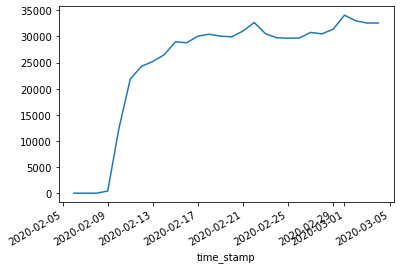

In [15]:
df.groupby('time_stamp')['user_id'].count().plot()

<AxesSubplot:>

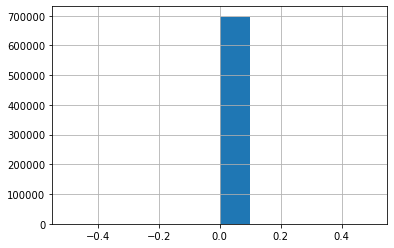

In [17]:
df['revenue_on_event'].hist()

In [18]:
df[['revenue_on_event',
       'revenue_on_other_activities', 'gold_on_event',
       'gold_on_other_activities']].describe()

,revenue_on_event,revenue_on_other_activities,gold_on_event,gold_on_other_activities
count,696840.0,696840.0,45412.000000,168193.000000
mean,0.0,0.0,1992.865322,936.481899
std,0.0,0.0,3895.541280,3522.989145
min,0.0,0.0,500.000000,100.000000
25%,0.0,0.0,500.000000,500.000000
50%,0.0,0.0,1000.000000,600.000000
75%,0.0,0.0,2400.000000,1000.000000
max,0.0,0.0,189600.000000,755950.000000


<AxesSubplot:>

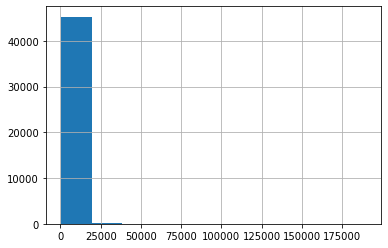

In [20]:
df['gold_on_event'].hist()

<AxesSubplot:>

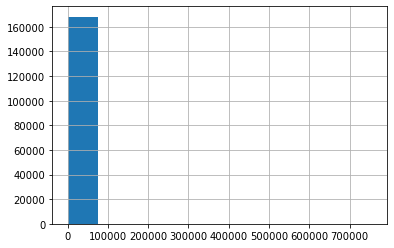

In [22]:
df['gold_on_other_activities'].hist()

In [25]:
# поскольку считать такое распределение исходя из статистики плохая затея закодируем в бинарные признаки конверсия либо нет категории
# gold_on_event -> gold_on_event_flag и 	gold_on_other_activities -> gold_on_other_activities_flag
df['gold_on_event_flag'] = (df['gold_on_event'] > 0)*1
df['gold_on_other_activities_flag'] = (df['gold_on_other_activities'] > 0)*1

In [27]:
df

,AbGroup,user_id,time_stamp,install_date,event_name,platform,network_name,country_name,InGameTime,LastCompletedLevel,avg_energy_amount,revenue_on_event,revenue_on_other_activities,gold_on_event,gold_on_other_activities,gold_on_event_flag,gold_on_other_activities_flag
0,Control,d60ebcaecff2dc1d360a8a41271e6fd8a902c107,2020-02-10,2019-11-10,ResourceSpend,itunes,Organic,United Kingdom of Great Britain and Northern I...,276180,345,54.0,0.0,0.0,NaN,NaN,0,0
1,Test,f6e385b0ab43d5aea9cfcc408aa84029a4ea5fdb,2020-03-04,2019-11-05,ResourceSpend,itunes,Paid,United States of America,166095,199,50.0,0.0,0.0,NaN,NaN,0,0
2,Control,a4c80c8524e2c11cc238553d7b02da01ce2aad66,2020-02-26,2020-01-02,ResourceSpend,itunes,Paid,Canada,240986,84,39.0,0.0,0.0,NaN,NaN,0,0
3,Control,7ea2e4599ae33760c307e254839317bd5b17a63c,2020-02-21,2020-01-13,ResourceSpend,itunes,Organic,France,989822,1176,21.0,0.0,0.0,NaN,NaN,0,0
4,Control,6495168982929360dc6d84bf0766d8963a7ddc41,2020-02-18,2020-02-05,ResourceSpend,itunes,Paid,Spain,52106,66,43.0,0.0,0.0,500.0,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696835,Control,cb394bfaa14de91ca99f566e1cede909285dc338,2020-03-01,2019-11-03,ResourceSpend,itunes,Paid,Canada,73805,101,23.0,0.0,0.0,NaN,NaN,0,0
696836,Test,b61b6d950bc376fc23581fa9c8e4d3c75d2dcd9a,2020-03-04,2020-01-03,ResourceSpend,itunes,Organic,Spain,733369,415,62.0,0.0,0.0,NaN,NaN,0,0
696837,Control,be989a271b16dfa4e9ac2d877a07ce0f2fdb456c,2020-02-29,2019-01-13,ResourceSpend,itunes,Organic,Germany,75273,331,22.0,0.0,0.0,NaN,NaN,0,0
696838,Control,5435fa8319c96097de76557f077659ce4f187262,2020-02-28,2019-02-14,ResourceSpend,itunes,Organic,Germany,908230,1287,58.0,0.0,0.0,NaN,NaN,0,0


In [29]:
(df.groupby(['AbGroup'])
 [['gold_on_event_flag', 'gold_on_event']]
 .agg({'gold_on_event_flag':['count', 'mean'],
      'gold_on_event':['mean', 'median']})
)

gold_on_event_flag          gold_on_event        
                     count     mean          mean  median
AbGroup                                                  
Control             558070  0.06523   1965.211658  1000.0
Test                138770  0.06492   2104.606505  1500.0

In [32]:
t = df.groupby('user_id')['AbGroup'].nunique().reset_index()

In [34]:
t[t['AbGroup'] > 1]

,user_id,AbGroup
202,007a61c7cc84aa559280c6d222aa3e15cb5e0114,2
208,007c891d5eb34c1398966a836d74a123452384de,2
895,02125379d8faf43debf755edfb32758ea5d789d8,2
1097,028e3fc09324ac6df71fccf432dabe44e476956c,2
1107,02977b73d35305fc135ea01bfcc9e1aa334d480a,2
...,...,...
110097,fe08c305b0317eecc6b5cf3cc5362fc912afdc0b,2
110362,fea60891a7ef95c7b95a0b1e58cb9d755684b3de,2
110480,fef449646b98d04def88b9ddb45e7c43bd9a278a,2
110515,ff079e7288b379b4e47650da302a5cc23e8c7ad3,2
